In [1]:
import numpy as np

In [2]:
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import matthews_corrcoef

In [3]:
positive_class = 1
negative_class = 0
num_of_positive_class = 1000
num_of_negative_class = 10000
proportion_of_predicted_for_pos_type_1 = 0.3
proportion_of_predicted_for_pos_type_2 = 1 - proportion_of_predicted_for_pos_type_1
shape1_pos_type_1 = 12
shape2_pos_type_1 = 2
shape1_pos_type_2 = 3
shape2_pos_type_2 = 4
shape1_neg = 2 
shape2_neg = 3

In [4]:
actual = np.concatenate([
    np.repeat(positive_class, num_of_positive_class),
    np.repeat(negative_class, num_of_negative_class)
])

In [5]:
predicted = np.concatenate([
    np.random.beta(
        a=shape1_pos_type_1,
        b=shape2_pos_type_1,
        size=int(np.floor(proportion_of_predicted_for_pos_type_1 * num_of_positive_class))
    ),
    np.random.beta(
        a=shape1_pos_type_2,
        b=shape2_pos_type_2,
        size=int(np.floor(proportion_of_predicted_for_pos_type_2 * num_of_positive_class))
    ),
    np.random.beta(
        a=shape1_neg,
        b=shape2_neg,
        size=num_of_negative_class
    )
])

In [6]:
# from sklearn.ensemble import RandomForestClassifier
# from sklearn.datasets import make_classification

# X, actual = make_classification(n_samples=1000, n_features=4,
#                            n_informative=2, n_redundant=0,
#                            random_state=0, shuffle=False)
# clf = RandomForestClassifier(max_depth=2, random_state=0)
# clf.fit(X, y)

# # get probabilistic predictions
# predicted = clf.predict_proba(X)[0:,0]

In [7]:
# len(actual), len(predicted)

In [8]:
# # get precision recall values across automated range of thresholds
# precision, recall, thresholds = precision_recall_curve(actual, predicted)

In [106]:
# define n thresholds
n_bins = 100
thresholds = np.linspace(0.001, 0.999, num=n_bins, endpoint=True)

# global lists
mcc = list()
precision = list()
recall = list()

# define range of thresholds

# for range of thresholds...
for i, tau in enumerate(thresholds):
    # binarise probabilistic predictions
    y_preds_clf_i = np.where(predicted > thresholds[i], 1, 0)
    true_pos = len(y_preds_clf_i[(y_preds_clf_i == 1) & (actual == 1)])
    false_pos = len(y_preds_clf_i[(y_preds_clf_i == 1) & (actual == 0)])
    false_neg = len(y_preds_clf_i[(y_preds_clf_i == 0) & (actual == 1)])
    
    # matthews correlation coefficients
    mcc_i = matthews_corrcoef(actual, y_preds_clf_i)

    # precision
    if false_pos > 0:
        precision_i = true_pos / (true_pos + false_pos)
    else:
        precision_i = 0
        
    # recall
    if false_pos > 0:
        recall_i = true_pos / (true_pos + false_neg)
    else:
        recall_i = 0
    
    # append to global lists
    mcc.append(mcc_i)
    precision.append(precision_i)
    recall.append(recall_i)

# lists to array
mcc = np.array(mcc)
precision = np.array(precision)
recall = np.array(recall)

# normalise MCC from [-1, 1] to [0, 1]
mcc = (mcc + 1) / 2

# get F1 scores
f1_scores = 2 * (precision * recall) / (precision + recall)

/Users/joe.gallagher/anaconda3/envs/env-test/lib/python3.7/site-packages/sklearn/metrics/classification.py:872: RuntimeWarning: invalid value encountered in double_scalars
  mcc = cov_ytyp / np.sqrt(cov_ytyt * cov_ypyp)
/Users/joe.gallagher/.local/lib/python3.7/site-packages/ipykernel_launcher.py:49: RuntimeWarning: invalid value encountered in true_divide


In [134]:
# idx(MCC) -> NaN where idx(f1) == NaN
f1_nan_idx = np.where(np.isnan(f1_scores))[0]
mcc[f1_nan_idx] = np.nan

(-0.05, 1.05)

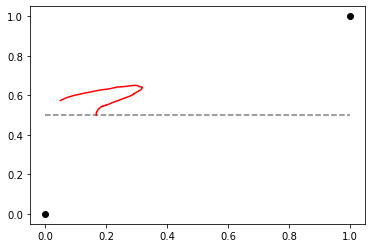

In [136]:
import matplotlib.pyplot as plt

# plot mcc-f1
fig, ax = plt.subplots()
ax.plot(f1_scores, mcc, c='r')
ax.plot(0, 0, 'o', c='k')
ax.plot(1, 1, 'o', c='k')
plt.hlines(0.5, 0, 1, ls='--', alpha=0.5)
ax.set_xlim([-0.05,1.05])
ax.set_ylim([-0.05,1.05])

In [149]:
# get the index of the point with largest normalized MCC ("point" refers to the point on the MCC-F1 curve)
index_of_max_mcc = np.nanargmax(mcc)

# define points on the MCC-F1 curve located on the left of the point with the highest normalized MCC as "left curve"
mcc_left = mcc[0:index_of_max_mcc]
f_left = f1_scores[0:index_of_max_mcc]

mcc_right = mcc[(index_of_max_mcc):len(mcc)]
f_right = f1_scores[(index_of_max_mcc):len(f1_scores)]

# divide the range of normalized MCC into subranges
unit_len = (max(mcc) - min(mcc)) / n_bins

In [174]:
# calculate the sum of mean distances from the left curve to the point (1, 1)
mean_distances_left = []
for i in range(n_bins):
    # find all the points on the left curve with normalized MCC between unit_len*(i-1) and unit_len*i
    idx = (mcc_left >= min(mcc) + (i-1) * unit_len) & (mcc_left <= min(mcc) + i * unit_len)
            
    sum_of_distance_within_subrange = 0
    for pos, mask in enumerate(idx):
        d = np.sqrt((mcc_left[pos] - 1)**2 + (f_left[pos] - 1)**2) * mask
        d = np.where(np.isnan(d), 0, d)
        sum_of_distance_within_subrange = sum_of_distance_within_subrange + d
        
    mean_distances_left.append(sum_of_distance_within_subrange / np.sum(idx))

/Users/joe.gallagher/.local/lib/python3.7/site-packages/ipykernel_launcher.py:13: RuntimeWarning: invalid value encountered in double_scalars
  del sys.path[0]


In [187]:
# calculate the sum of mean distances from the right curve to the point (1, 1)
mean_distances_right = []
for i in range(n_bins):
    # find all the points on the right curve with normalized MCC between unit_len*(i-1) and unit_len*i
    idx = (mcc_right >= min(mcc) + (i-1) * unit_len) & (mcc_right <= min(mcc) + i * unit_len)
            
    sum_of_distance_within_subrange = 0
    for pos, mask in enumerate(idx):
        d = np.sqrt((mcc_right[pos] - 1)**2 + (f_right[pos] - 1)**2) * mask
        d = np.where(np.isnan(d), 0, d)
        sum_of_distance_within_subrange = sum_of_distance_within_subrange + d
        
    mean_distances_right.append(sum_of_distance_within_subrange / np.sum(idx))

/Users/joe.gallagher/.local/lib/python3.7/site-packages/ipykernel_launcher.py:5: RuntimeWarning: invalid value encountered in greater_equal
  """
/Users/joe.gallagher/.local/lib/python3.7/site-packages/ipykernel_launcher.py:5: RuntimeWarning: invalid value encountered in less_equal
  """
/Users/joe.gallagher/.local/lib/python3.7/site-packages/ipykernel_launcher.py:13: RuntimeWarning: invalid value encountered in double_scalars
  del sys.path[0]


In [177]:
# get rid of NAs and sum the mean distances
num_of_na_left = sum(np.isnan(mean_distances_left))
sum_of_mean_distances_left_no_na = np.nansum(mean_distances_left)

# get rid of NAs and sum the mean distances
num_of_na_right = sum(np.isnan(mean_distances_right))
sum_of_mean_distances_right_no_na = np.nansum(mean_distances_right)

In [183]:
# calculate the MCC-F1 metric
mccf1_metric = 1 - ((sum_of_mean_distances_left_no_na + sum_of_mean_distances_right_no_na) / (n_bins*2 - num_of_na_left - num_of_na_right)) / np.sqrt(2)

In [184]:
mccf1_metric

0.37044051928120025

In [208]:
# find the best threshold
eu_distance = []
for i in range(len(mcc)):
    eu_distance.append(np.sqrt((1 - mcc[i])**2 + (1 - f1_scores[i])**2))
    
best_threshold_idx = np.nanargmin(eu_distance)

best_threshold = thresholds[best_threshold_idx]

In [209]:
best_threshold

0.7772222222222223

## Define funs

In [269]:
import numpy as np
from sklearn.metrics import matthews_corrcoef
import matplotlib.pyplot as plt


def __mcc_fun(true_pos, false_pos, true_neg, false_neg):
    mcc = ((true_pos * true_neg) - (false_pos * false_neg)) / np.sqrt(
        (true_pos + false_pos) * (true_pos + false_neg) * (true_neg + false_pos) * (true_neg + false_neg)
    )
    if np.isnan(mcc):
        mcc = 0
    
    return mcc

def __precision_fun(true_pos, false_pos):
    # precision
    if false_pos > 0:
        precision = true_pos / (true_pos + false_pos)
    else:
        precision = 0
        
    return precision
        
def __recall_fun(true_pos, false_neg):
    if false_pos > 0:
        recall = true_pos / (true_pos + false_neg)
    else:
        recall = 0
        
    return recall


def get_mccf1_metrics(actual, predicted, n_bins=100):
    # define n thresholds
    n_bins = 100
    thresholds = np.linspace(0.001, 0.999, num=n_bins, endpoint=True)

    # global lists
    mcc = list()
    precision = list()
    recall = list()

    # define range of thresholds

    # for range of thresholds...
    for i, tau in enumerate(thresholds):
        # binarise probabilistic predictions
        y_preds_clf_i = np.where(predicted > thresholds[i], 1, 0)
        true_pos = len(y_preds_clf_i[(y_preds_clf_i == 1) & (actual == 1)])
        false_pos = len(y_preds_clf_i[(y_preds_clf_i == 1) & (actual == 0)])
        true_neg = len(y_preds_clf_i[(y_preds_clf_i == 0) & (actual == 0)])
        false_neg = len(y_preds_clf_i[(y_preds_clf_i == 0) & (actual == 1)])

        # matthews correlation coefficients
        mcc_i = __mcc_fun(true_pos=true_pos, false_pos=false_pos, true_neg=true_neg, false_neg=false_neg)

        # precision
        precision_i = __precision_fun(true_pos=true_pos, false_pos=false_pos)

        # recall
        recall_i = __recall_fun(true_pos=true_pos, false_neg=false_neg)

        # append to global lists
        mcc.append(mcc_i)
        precision.append(precision_i)
        recall.append(recall_i)

    # lists to array
    mcc = np.array(mcc)
    precision = np.array(precision)
    recall = np.array(recall)

    # normalise MCC from [-1, 1] to [0, 1]
    mcc = (mcc + 1) / 2

    # get F1 scores
    f1_scores = 2 * (precision * recall) / (precision + recall)
    
    # idx(MCC) -> NaN where idx(f1) == NaN
    f1_nan_idx = np.where(np.isnan(f1_scores))[0]
    mcc[f1_nan_idx] = np.nan

    return precision, recall, mcc, f1_scores


def plot_mccf1(actual, predicted, n_bins=100):
    # get metrics
    precision, recall, mcc, f1_scores = get_mccf1_metrics(actual, predicted, n_bins=n_bins)

    # plot
    fig, ax = plt.subplots()
    ax.plot(f1_scores, mcc, c='r')
    ax.plot(0, 0, 'o', c='k')
    ax.plot(1, 1, 'o', c='k')
    plt.hlines(0.5, 0, 1, ls='--', alpha=0.5)
    ax.set_xlim([-0.05,1.05])
    ax.set_ylim([-0.05,1.05])
    
    
def calc_mccf1(actual, predicted, n_bins=100):
    # get metrics
    precision, recall, mcc, f1_scores = get_mccf1_metrics(actual, predicted, n_bins=n_bins)
    
    # get the index of the point with largest normalized MCC ("point" refers to the point on the MCC-F1 curve)
    index_of_max_mcc = np.nanargmax(mcc)

    # define points on the MCC-F1 curve located on the left of the point with the highest normalized MCC as "left curve"
    mcc_left = mcc[0:index_of_max_mcc]
    f_left = f1_scores[0:index_of_max_mcc]

    mcc_right = mcc[(index_of_max_mcc):len(mcc)]
    f_right = f1_scores[(index_of_max_mcc):len(f1_scores)]

    # divide the range of normalized MCC into subranges
    unit_len = (max(mcc) - min(mcc)) / n_bins
    
    # calculate the sum of mean distances from the left curve to the point (1, 1)
    mean_distances_left = []
    for i in range(n_bins):
        # find all the points on the left curve with normalized MCC between unit_len*(i-1) and unit_len*i
        idx = (mcc_left >= min(mcc) + (i-1) * unit_len) & (mcc_left <= min(mcc) + i * unit_len)

        sum_of_distance_within_subrange = 0
        for pos, mask in enumerate(idx):
            d = np.sqrt((mcc_left[pos] - 1)**2 + (f_left[pos] - 1)**2) * mask
            d = np.where(np.isnan(d), 0, d)
            sum_of_distance_within_subrange = sum_of_distance_within_subrange + d

        mean_distances_left.append(sum_of_distance_within_subrange / np.sum(idx))
        
    # calculate the sum of mean distances from the right curve to the point (1, 1)
    mean_distances_right = []
    for i in range(n_bins):
        # find all the points on the right curve with normalized MCC between unit_len*(i-1) and unit_len*i
        idx = (mcc_right >= min(mcc) + (i-1) * unit_len) & (mcc_right <= min(mcc) + i * unit_len)

        sum_of_distance_within_subrange = 0
        for pos, mask in enumerate(idx):
            d = np.sqrt((mcc_right[pos] - 1)**2 + (f_right[pos] - 1)**2) * mask
            d = np.where(np.isnan(d), 0, d)
            sum_of_distance_within_subrange = sum_of_distance_within_subrange + d

        mean_distances_right.append(sum_of_distance_within_subrange / np.sum(idx))
        
    # get rid of NAs and sum the mean distances
    num_of_na_left = sum(np.isnan(mean_distances_left))
    sum_of_mean_distances_left_no_na = np.nansum(mean_distances_left)

    # get rid of NAs and sum the mean distances
    num_of_na_right = sum(np.isnan(mean_distances_right))
    sum_of_mean_distances_right_no_na = np.nansum(mean_distances_right)

    # calculate the MCC-F1 metric
    mccf1_metric = 1 - ((sum_of_mean_distances_left_no_na + sum_of_mean_distances_right_no_na) / (n_bins*2 - num_of_na_left - num_of_na_right)) / np.sqrt(2)
    
    # find the best threshold
    eu_distance = []
    for i in range(len(mcc)):
        eu_distance.append(np.sqrt((1 - mcc[i])**2 + (1 - f1_scores[i])**2))

    best_threshold_idx = np.nanargmin(eu_distance)
    best_threshold = thresholds[best_threshold_idx]
    
    return mccf1_metric, best_threshold

/Users/joe.gallagher/.local/lib/python3.7/site-packages/ipykernel_launcher.py:8: RuntimeWarning: invalid value encountered in double_scalars
  
/Users/joe.gallagher/.local/lib/python3.7/site-packages/ipykernel_launcher.py:77: RuntimeWarning: invalid value encountered in true_divide


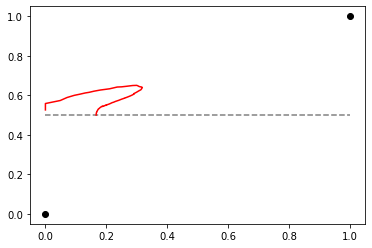

In [270]:
plot_mccf1(actual, predicted, 100)

In [271]:
calc_mccf1(actual, predicted, 100)

/Users/joe.gallagher/.local/lib/python3.7/site-packages/ipykernel_launcher.py:8: RuntimeWarning: invalid value encountered in double_scalars
  
/Users/joe.gallagher/.local/lib/python3.7/site-packages/ipykernel_launcher.py:77: RuntimeWarning: invalid value encountered in true_divide
/Users/joe.gallagher/.local/lib/python3.7/site-packages/ipykernel_launcher.py:129: RuntimeWarning: invalid value encountered in double_scalars
/Users/joe.gallagher/.local/lib/python3.7/site-packages/ipykernel_launcher.py:135: RuntimeWarning: invalid value encountered in greater_equal
/Users/joe.gallagher/.local/lib/python3.7/site-packages/ipykernel_launcher.py:135: RuntimeWarning: invalid value encountered in less_equal
/Users/joe.gallagher/.local/lib/python3.7/site-packages/ipykernel_launcher.py:143: RuntimeWarning: invalid value encountered in double_scalars


(0.36462169175394854, 0.7772222222222223)